In [ ]:
%env LLM_BASE_URL=https://dashscope.aliyuncs.com/compatible-mode/v1
%env LLM_API_KEY=sk-替换为自己的key

In [2]:
%%capture --no-stderr
!pip install -U langchain langchain-community langchain-openai langchain_chroma pypdf sentence_transformers shutil openpyxl FlagEmbedding

In [3]:
import os
import pandas as pd

In [4]:
import sys

In [5]:
sys.path.append('late-chunking')

In [6]:
expr_version = 'split_05_late_chunking'

preprocess_output_dir = os.path.join(os.path.pardir, 'outputs', 'v1_20240713')
qa_df = pd.read_excel(os.path.join(preprocess_output_dir, 'question_answer.xlsx'))
expr_dir = os.path.join(os.path.pardir, 'experiments', expr_version)

os.makedirs(expr_dir, exist_ok=True)

# 读取文档

In [7]:
from langchain_community.document_loaders import PyPDFLoader
import re

loader = PyPDFLoader(os.path.join(os.path.pardir, 'data', '2024全球经济金融展望报告.pdf'))
pdf_documents = loader.load()

# 把页眉页脚去掉
pattern = r"^全球经济金融展望报告\n中国银行研究院 \d+ 2024年"
# PyPDFLoader解析的文档
pdf_document = '\n\n'.join(re.sub(pattern, '', doc.page_content) for doc in pdf_documents)
# MinerU解析的文档
markdown_document = open(os.path.join(os.path.pardir, 'outputs', 'MinerU_parsed_20241204', '2024全球经济金融展望报告.md')).read()

In [8]:
len(pdf_document)

31202

In [9]:
len(markdown_document)

33940

# 文档切分

In [10]:
import os
import pickle
import requests
from langchain.schema import Document

In [11]:
model_path = 'BAAI/bge-m3'

In [12]:
from transformers import AutoModel, AutoTokenizer
import torch
import json
import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

# load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
model = AutoModel.from_pretrained(model_path, trust_remote_code=True, device_map=device)

device: cuda


- 原文：https://jina.ai/news/late-chunking-in-long-context-embedding-models/
- 代码：https://colab.research.google.com/drive/15vNZb6AsU7byjYoaEtXuNu567JWNzXOz?usp=sharing

In [13]:
from tqdm.auto import trange
import numpy as np

# 这个方法来自：https://github.com/weaviate/late-chunking-experiments/blob/main/late_chunking.ipynb
def chunk_by_tokens(input_text: str, tokenizer: callable, chunk_size: int = 512):
    """
    Split the input text into chunks of approximately chunk_size tokens
    """
    tokens = tokenizer(input_text, return_offsets_mapping=True, add_special_tokens=False)
    token_offsets = tokens['offset_mapping']
    
    chunks = []
    span_annotations = []
    
    for i in range(0, len(token_offsets), chunk_size):
        chunk_end = min(i + chunk_size, len(token_offsets))
        if chunk_end - i > 0:
            start_offset = token_offsets[i][0]
            end_offset = token_offsets[chunk_end - 1][1]
            chunks.append(input_text[start_offset:end_offset])
            span_annotations.append((i, chunk_end))
    
    return chunks, span_annotations

def chunk_by_sentences(input_text: str, tokenizer: callable):
    """
    Split the input text into sentences using the tokenizer
    :param input_text: The text snippet to split into sentences
    :param tokenizer: The tokenizer to use
    :return: A tuple containing the list of text chunks and their corresponding token spans
    """
    inputs = tokenizer(input_text, return_tensors='pt', return_offsets_mapping=True)
    punctuation_mark_ids = [tokenizer.convert_tokens_to_ids(punc) for punc in ('。', '？', '！')]
    sep_id = tokenizer.convert_tokens_to_ids('[SEP]')
    token_offsets = inputs['offset_mapping'][0]
    token_ids = inputs['input_ids'][0]
    chunk_positions = [
        (i, int(start + 1))
        for i, (token_id, (start, end)) in enumerate(zip(token_ids, token_offsets))
        if token_id in punctuation_mark_ids
        and (
            token_offsets[i + 1][0] - token_offsets[i][1] > 0
            or token_ids[i + 1] == sep_id
        )
    ]
    chunks = [
        input_text[x[1] : y[1]]
        for x, y in zip([(1, 0)] + chunk_positions[:-1], chunk_positions)
    ]
    span_annotations = [
        (x[0], y[0]) for (x, y) in zip([(1, 0)] + chunk_positions[:-1], chunk_positions)
    ]
    return chunks, span_annotations

def document_to_token_embeddings(model, tokenizer, document, batch_size=4096):
    tokenized_document = tokenizer(document, return_tensors="pt")
    tokens = tokenized_document.tokens()

    outputs = []
    for i in trange(0, len(tokens), batch_size):
        
        start = i
        end   = min(i + batch_size, len(tokens))

        batch_inputs = {k: v[:, start:end].to(device) for k, v in tokenized_document.items()}

        with torch.no_grad():
            model_output = model(**batch_inputs)

        outputs.append(model_output.last_hidden_state)

    model_output = torch.cat(outputs, dim=1)
    return model_output

def late_chunking(token_embeddings, span_annotation, max_length=None):
    outputs = []
    for embeddings, annotations in zip(token_embeddings, span_annotation):
        if (max_length is not None):
            annotations = [
                (start, min(end, max_length - 1))
                for (start, end) in annotations
                if start < (max_length - 1)
            ]
        pooled_embeddings = []

        for idx, (start, end) in enumerate(annotations):
            assert chunks[idx] == tokenizer.decode(doc_input_ids[start: end]), f"idx={idx}, (start, end)={(start, end)}, chunks[idx]={chunks[idx]}, tokenizer.decode(doc_input_ids[start: end])={tokenizer.decode(doc_input_ids[start: end])}"
            if (end - start) >= 1:
                pooled_embeddings.append(
                    # embeddings[start:end].sum(dim=0) / (end - start)
                    embeddings[start:end].mean(dim=0).cpu().numpy()
                )
            else:
                raise ValueError()
                   
        pooled_embeddings = [
            embedding / np.linalg.norm(embedding) for embedding in pooled_embeddings
        ]
        outputs.append(pooled_embeddings)
    return outputs

In [17]:
# debug begin 由于总体切分逻辑相对复杂，下面对这个过程进行调试，检查切分逻辑

In [18]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

splitter = RecursiveCharacterTextSplitter(
    chunk_size=1024,
    chunk_overlap=0,
    separators=['\n\n\n', '\n\n']
)
# chunks = splitter.split_text(pdf_document)
chunks = splitter.split_text(markdown_document)
chunks = [tokenizer.decode(tokenizer(text.strip(), return_tensors='pt')['input_ids'][0, 1:-1]) for text in chunks]
processed_doc = '\n\n'.join(chunks)
doc_tokens = tokenizer(processed_doc, return_tensors='pt')

len(chunks)

Token indices sequence length is longer than the specified maximum sequence length for this model (20751 > 8192). Running this sequence through the model will result in indexing errors


40

In [19]:
span_annotations = []

doc_input_ids = doc_tokens['input_ids'][0]
start_pos = 1
seperator_len = len(tokenizer('\n\n', return_tensors='pt')['input_ids'][0]) - 2

for chunk_idx, chunk in enumerate(chunks):
    # 1: -1排除首位的<s></s>
    chunk_input_ids = tokenizer(chunk, return_tensors='pt')['input_ids'][0][1:-1]
    chunk_token_len = len(chunk_input_ids)
    # 有时候chunk_input_ids decode开头2位都不是实际文本
    if (doc_input_ids[start_pos: start_pos + chunk_token_len] == chunk_input_ids).detach().numpy().mean() != 1:
        start_pos += 1
    
    assert (doc_input_ids[start_pos: start_pos + chunk_token_len] == chunk_input_ids).detach().numpy().mean() == 1, chunk_idx
    span_annotations.append((start_pos, start_pos + chunk_token_len))
    start_pos += chunk_token_len

In [20]:
len(span_annotations)

40

In [21]:
span_annotations[23]

(11849, 12435)

In [22]:
tokenizer.decode(doc_input_ids[span_annotations[23][0]:span_annotations[23][1]])

'2024年,跨境资本流动可能将发生趋势性变化,跨境资本回流美国态势会进一步放缓。惠誉、穆迪下调美债信用评级或评级展望将影响跨境资本回流美国的趋势,投资者增持美债的意愿降低。欧元区将延续资本净流出态势,FDI和银行主导的其他投资仍可能成为欧元区资本外流的主要推动力量。随着负利率政策结束,日本跨境资本净流出下降,证券投资和其他投资净流出或将减少。跨境资金流向新兴经济体的节奏有望提速,流向新兴经济体的资金仍将以组合投资、其他投资为主导。 # (三)汇率市场:美元指数高位震荡后走弱,新兴市场货币币值小幅回升 2023年以来,美元指数始终保持高位,在100-105区间波动,7月初开始震荡走高,之后逐渐从高位回落。受美联储货币政策影响,2023年11月15日,美元指数为104.4,较年初上涨 $0.6\\%$ (图17)。主要发达经济体货币汇率走势涨跌不一。2023年欧元和英镑兑美元汇率均呈现宽幅震荡态势,与年初相比欧元和英镑分别小幅升值 $1.4\\%$ 、 $2.8\\%$ ;日元币值持续走低,贬值幅度达 $13.3\\%$ ;瑞士法郎在震荡中升值 $4.2\\%$ 。美元升值背景下,新兴经济体货币遭受冲击。截至11月15日,俄罗斯卢布、土耳其里拉和阿根廷比索跌幅分别高达 $18.2\\%$ 、 $34.8\\%$ 、 $49.9\\%$,面临较大的汇率波动风险(图18)。![](images/505b072a246f1b79dcd689ed41c1771a377cfbb6b84ce33a9c4e7f7a453f5856.jpg) 图17:2023年美元指数变动趋势 资料来源:Wind,中国银行研究院![](images/39e12dda59e8e920ae43789e542c89192b924c2bc9a807c73786be598affa3cd.jpg) 图18:主要货币兑美元汇率较2023年年初变动 $(\\%)$ ) 注:数据截至2023年11月15日。 资料来源:Wind,中国银行研究院展望2024年,全球汇率市场走势主要呈现以下特征。 # 1.美元在保持一段时间强势后走弱,欧元英镑仍维持区间震荡'

In [23]:
chunks[23]

'2024年,跨境资本流动可能将发生趋势性变化,跨境资本回流美国态势会进一步放缓。惠誉、穆迪下调美债信用评级或评级展望将影响跨境资本回流美国的趋势,投资者增持美债的意愿降低。欧元区将延续资本净流出态势,FDI和银行主导的其他投资仍可能成为欧元区资本外流的主要推动力量。随着负利率政策结束,日本跨境资本净流出下降,证券投资和其他投资净流出或将减少。跨境资金流向新兴经济体的节奏有望提速,流向新兴经济体的资金仍将以组合投资、其他投资为主导。 # (三)汇率市场:美元指数高位震荡后走弱,新兴市场货币币值小幅回升 2023年以来,美元指数始终保持高位,在100-105区间波动,7月初开始震荡走高,之后逐渐从高位回落。受美联储货币政策影响,2023年11月15日,美元指数为104.4,较年初上涨 $0.6\\%$ (图17)。主要发达经济体货币汇率走势涨跌不一。2023年欧元和英镑兑美元汇率均呈现宽幅震荡态势,与年初相比欧元和英镑分别小幅升值 $1.4\\%$ 、 $2.8\\%$ ;日元币值持续走低,贬值幅度达 $13.3\\%$ ;瑞士法郎在震荡中升值 $4.2\\%$ 。美元升值背景下,新兴经济体货币遭受冲击。截至11月15日,俄罗斯卢布、土耳其里拉和阿根廷比索跌幅分别高达 $18.2\\%$ 、 $34.8\\%$ 、 $49.9\\%$,面临较大的汇率波动风险(图18)。![](images/505b072a246f1b79dcd689ed41c1771a377cfbb6b84ce33a9c4e7f7a453f5856.jpg) 图17:2023年美元指数变动趋势 资料来源:Wind,中国银行研究院![](images/39e12dda59e8e920ae43789e542c89192b924c2bc9a807c73786be598affa3cd.jpg) 图18:主要货币兑美元汇率较2023年年初变动 $(\\%)$ ) 注:数据截至2023年11月15日。 资料来源:Wind,中国银行研究院展望2024年,全球汇率市场走势主要呈现以下特征。 # 1.美元在保持一段时间强势后走弱,欧元英镑仍维持区间震荡'

In [24]:
# debug end

整篇文档的Embedding

In [25]:
document_embeddings = document_to_token_embeddings(model, tokenizer, processed_doc, batch_size=1024)

  0%|          | 0/21 [00:00<?, ?it/s]

In [26]:
len(document_embeddings[0])

20751

In [27]:
late_embeddings = late_chunking(document_embeddings, [span_annotations])

# 检索

此处为了兼容Chroma想粮库逻辑，直接根据片段查找已经Late Chunking好的向量

In [28]:
from langchain_core.embeddings import Embeddings

class CustomEmbeddingFn(Embeddings):
    def embed_documents(self, texts: list[str]) -> list[list[float]]:
        ret = []
        for text in texts:
            idx = chunks.index(text)
            ret.append(late_embeddings[0][idx])
            # ret.append(self.embed_query(text))

        assert len(ret) == len(texts)
        return ret

    def embed_query(self, text: str) -> list[float]:
        tokenized_document = tokenizer(text, return_tensors="pt").to(device)
        with torch.no_grad():
            model_output = model(**tokenized_document)
        # (bz, seq_len, emb_sz)
        hidden_states = model_output.last_hidden_state
        hidden_states = hidden_states[0]
        emb = hidden_states[1:-1].sum(dim=0) / (len(hidden_states))
        emb /= torch.norm(emb)
        return emb.cpu().numpy()

In [29]:
cust_emb_fn = CustomEmbeddingFn()

In [30]:
chunks[0]

'# 全球经济金融展望报告 2024年年报(总第57期) 报告日期:2023年12月12日 # 要点 ●2023 年全球经济增长动力持续回落,各国复苏分化,发达经济体增速明显放缓,新兴经济体整体表现稳定。全球贸易增长乏力,各国生产景气度逐渐回落,内需对经济的拉动作用减弱。欧美央行货币政策紧缩态势放缓,美元指数高位震荡后走弱,全球股市表现总体好于预期,但区域分化明显。高利率环境抑制债券融资需求,债券违约风险持续上升。 $\\bullet$ 展望2024 年,预计全球经济复苏将依旧疲软,主要经济体增长态势和货币政策走势将进一步分化。欧美央行大概率结束本轮紧缩货币周期,美元指数将逐步走弱,流向新兴经济体的跨境资本将增加。国际原油市场短缺格局或延续,新能源发展成为重点。 $\\bullet$ 海湾六国经济发展与投资前景、高利率和高债务对美国房地产市场脆弱性的影响等热点问题值得关注。![](images/c7e6ce1606712e84e07a05bcf6016906efa3fc778e40fcd0e91ac4fcb5503b79.jpg) 主要经济体GDP 增速变化趋势(%) 资料来源:IMF,中国银行研究院 # 中国银行研究院全球经济金融研究课题组![](images/a5d0eb181c75231451c8f890ec50fe5822e2306a9beb543ca35a04880abbf639.jpg) 联系人:王有鑫 电话:010-66594127 邮件: wangyouxin_hq@bank-of-china.com # 全球经济复苏疲软,货币政策取向分化 ——中国银行全球经济金融展望报告(2024年)'

In [31]:
late_embeddings[0][0]

array([-0.01493518,  0.02493956, -0.01642812, ..., -0.00148642,
       -0.01115633, -0.02175757], dtype=float32)

In [32]:
cust_emb_fn.embed_documents([chunks[0]])

[array([-0.01493518,  0.02493956, -0.01642812, ..., -0.00148642,
        -0.01115633, -0.02175757], dtype=float32)]

In [33]:
cust_emb_fn.embed_query(chunks[0])

array([-0.01151318,  0.02350147, -0.01801374, ...,  0.01589576,
       -0.00841782, -0.01799052], dtype=float32)

In [34]:
np.dot(late_embeddings[0][0], cust_emb_fn.embed_query(chunks[0]).T)

0.97216177

In [35]:
from langchain.vectorstores import Chroma
import shutil

persist_directory = os.path.join(expr_dir, 'chroma', 'late_chunking')
shutil.rmtree(persist_directory, ignore_errors=True)
os.makedirs(persist_directory, exist_ok=True)

vector_db = Chroma.from_texts(
    chunks,
    embedding=CustomEmbeddingFn(),
    persist_directory=persist_directory
)

# 生成答案

In [36]:
from langchain.llms import Ollama

ollama_llm = Ollama(
    model='qwen2:7b-instruct',
    base_url='http://localhost:11434',
    top_k=1
)

/tmp/ipykernel_2513129/3342461511.py:3: LangChainDeprecationWarning: The class `Ollama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaLLM``.
  ollama_llm = Ollama(


In [37]:
import time

def rag(vector_db, llm, query, n_chunks=4):
    prompt_tmpl = """
你是一个金融分析师，擅长根据所获取的信息片段，对问题进行分析和推理。
你的任务是根据所获取的信息片段（<<<<context>>><<<</context>>>之间的内容）回答问题。
回答保持简洁，不必重复问题，不要添加描述性解释和与答案无关的任何内容。
已知信息：
<<<<context>>>
{{knowledge}}
<<<</context>>>

问题：{{query}}
请回答：
""".strip()
    chunks = vector_db.similarity_search(query, k=n_chunks)
    prompt = prompt_tmpl.replace('{{knowledge}}', '\n\n'.join([doc.page_content for doc in chunks])).replace('{{query}}', query)
    retry_count = 3

    resp = ''
    while retry_count > 0:
        try:
            resp = llm.invoke(prompt)
            break
        except Exception as e:
            retry_count -= 1
            sleeping_seconds = 2 ** (4 - retry_count)
            print(f"query={query}, error={e}, sleeping={sleeping_seconds}, remaining retry count={retry_count}")
            
            time.sleep(sleeping_seconds)
    
    return resp, chunks

In [38]:
prediction_df = qa_df[qa_df['dataset'] == 'test'][['uuid', 'question', 'qa_type', 'answer']].rename(columns={'answer': 'ref_answer'})

def predict(vector_db, llm, prediction_df, n_chunks):
    prediction_df = prediction_df.copy()
    answer_dict = {}

    for idx, row in tqdm(prediction_df.iterrows(), total=len(prediction_df)):
        uuid = row['uuid']
        question = row['question']
        answer, chunks = rag(vector_db, llm, question, n_chunks=n_chunks)
        assert len(chunks) <= n_chunks
        answer_dict[question] = {
            'uuid': uuid,
            'ref_answer': row['ref_answer'],
            'gen_answer': answer,
            'chunks': chunks
        }

    prediction_df.loc[:, 'gen_answer'] = prediction_df['question'].apply(lambda q: answer_dict[q]['gen_answer'])
    prediction_df.loc[:, 'chunks'] = prediction_df['question'].apply(lambda q: answer_dict[q]['chunks'])

    return prediction_df

In [39]:
save_path = os.path.join(expr_dir, 'pred_df.pkl')

In [40]:
from tqdm.auto import tqdm

pred_df = predict(vector_db, ollama_llm, prediction_df, n_chunks=3)
pickle.dump(pred_df, open(save_path, 'wb'))

  0%|          | 0/100 [00:00<?, ?it/s]

# 评估

In [41]:
from langchain_openai import ChatOpenAI
import time

judge_llm = ChatOpenAI(
    api_key=os.environ['LLM_API_KEY'],
    base_url=os.environ['LLM_BASE_URL'],
    model_name='qwen2-72b-instruct',
    temperature=0
)

def evaluate(prediction_df):
    """
    对预测结果进行打分
    :param prediction_df: 预测结果，需要包含问题，参考答案，生成的答案，列名分别为question, ref_answer, gen_answer
    :return 打分模型原始返回结果
    """
    prompt_tmpl = """
你是一个经济学博士，现在我有一系列问题，有一个助手已经对这些问题进行了回答，你需要参照参考答案，评价这个助手的回答是否正确，仅回复“是”或“否”即可，不要带其他描述性内容或无关信息。
问题：
<question>
{{question}}
</question>

参考答案：
<ref_answer>
{{ref_answer}}
</ref_answer>

助手回答：
<gen_answer>
{{gen_answer}}
</gen_answer>
请评价：
    """
    results = []

    for _, row in tqdm(prediction_df.iterrows(), total=len(prediction_df)):
        question = row['question']
        ref_answer = row['ref_answer']
        gen_answer = row['gen_answer']

        prompt = prompt_tmpl.replace('{{question}}', question).replace('{{ref_answer}}', str(ref_answer)).replace('{{gen_answer}}', gen_answer).strip()
        
        retry_count = 3
        result = ''
        
        while retry_count > 0:
            try:
                result = judge_llm.invoke(prompt).content
                break
            except Exception as e:
                retry_count -= 1
                sleeping_seconds = 2 ** (4 - retry_count)
                print(f"query={question}, error={e}, sleeping={sleeping_seconds}, remaining retry count={retry_count}")
                
                time.sleep(sleeping_seconds)
        
        results.append(result)

        time.sleep(1)
    return results

In [42]:
eval_save_path = os.path.join(expr_dir, 'eval.pkl')

In [43]:
pred_df['raw_score'] = evaluate(pred_df)
pred_df['score'] = (pred_df['raw_score'] == '是').astype(int)
pickle.dump(pred_df, open(eval_save_path, 'wb'))

  0%|          | 0/100 [00:00<?, ?it/s]

In [44]:
pred_df['score'].mean()

0.36

# 结果分析

## 首先检查一下预测结果

可以看出，大部分问题似乎都检索到了相同的知识片段

In [45]:
pred_df

,uuid,question,qa_type,ref_answer,gen_answer,chunks,raw_score,score
0,e73a0c9d-d42b-4350-a4c3-b38bf67c68a5,报告的发布机构是什么？,detailed,中国银行研究院,报告的发布机构是中国银行研究院。,"[page_content='本研究报告内容及观点仅供参考,不构成任何投资建议。对于本报告所...",是,1
1,e73a0c9d-d42b-4350-a4c3-b38bf67c68a5,报告的发布日期是什么时候？,detailed,2023年12月12日,报告的发布日期是2023年12月12日。,[page_content='# 全球经济金融展望报告 2024年年报(总第57期) 报告日...,是,1
2,e73a0c9d-d42b-4350-a4c3-b38bf67c68a5,2023年全球经济增长有什么特点？,detailed,全球经济增长动力持续回落，各国复苏分化，发达经济体增速放缓，新兴经济体表现稳定。,2023年全球经济增长动力持续回落，各国复苏存在较大差异。发达经济体增速明显放缓，新兴经济体...,[page_content='# 全球经济金融展望报告 2024年年报(总第57期) 报告日...,是,1
3,e73a0c9d-d42b-4350-a4c3-b38bf67c68a5,全球贸易增长情况如何？,detailed,全球贸易增长乏力。,全球贸易增长乏力，各国生产景气度逐渐回落，内需对经济的拉动作用减弱。,[page_content='# 全球经济金融展望报告 2024年年报(总第57期) 报告日...,是,1
5,e73a0c9d-d42b-4350-a4c3-b38bf67c68a5,展望2024年，全球经济复苏的预期如何？,detailed,全球经济复苏预计将依旧疲软。,预计2024年全球经济复苏将依旧疲软，主要经济体增长态势和货币政策将进一步分化。欧美央行大概...,[page_content='# 全球经济金融展望报告 2024年年报(总第57期) 报告日...,是,1
...,...,...,...,...,...,...,...,...
356,584ef542-c5b3-4336-8eae-c30d6f600b5f,2023年全球发展中国家在哪些重要的国际会议上展露出活跃的表现？,large_context,2023年，全球发展中国家在国际政经舞台上表现突出，参与的重要会议包括上海合作组织成员国元首...,根据提供的信息片段，没有直接提到2023年全球发展中国家在特定国际会议上的表现。信息主要关注...,[page_content='# 全球经济金融展望报告 2024年年报(总第57期) 报告日...,否,0
360,d4683862-fed6-4867-a255-29db66011c2a,2024年美联储的货币政策预期如何？,large_context,2024年美联储预计将暂停加息，但是利率水平将较长时间维持在高位，预计会维持每月950亿美元...,2024年，预计美联储将结束本轮紧缩货币周期，其货币政策路线尚不清晰。市场共识认为，当前的货...,[page_content='# 全球经济金融展望报告 2024年年报(总第57期) 报告日...,否,0
365,2accb7dd-1bd7-42c9-89ad-a32b6725c95a,2024年全球资金状况和货币市场基金的前景如何？,large_context,2024年，主要经济体将结束加息周期，资金流动性会呈现“紧平衡”状态，可能导致货币市场脆弱性...,2024年，预计全球经济复苏将保持疲软态势，主要经济体的增长和货币政策将进一步分化。在这一背...,[page_content='# 全球经济金融展望报告 2024年年报(总第57期) 报告日...,否,0
377,61c25726-912a-4bd4-981c-01e9cfa81951,面对经济增长放缓和全球经济挑战，海湾国家采取了什么措施？,large_context,为了应对经济增长放缓和全球经济挑战，沙特、阿联酋等国政府大力推动绿色经济转型和经济多元化改革...,报告中未直接提及海湾六国针对经济增长放缓和全球经济挑战的具体应对措施。不过，考虑到海湾国家通...,[page_content='# 全球经济金融展望报告 2024年年报(总第57期) 报告日...,否,0


## 检查以chunk作为Query来检索，看能否召回自己

In [46]:
embedding_fn = CustomEmbeddingFn()

chunk_retrieve_data = []
for chunk in chunks:
    retrieved_docs = vector_db.similarity_search_with_relevance_scores(chunk, k=1)
    chunk_retrieve_data.append({
        'orig': chunk,
        'retrieved': retrieved_docs[0][0].page_content,
        'similarity': retrieved_docs[0][1]
    })

In [47]:
retrieved_dbg_df = pd.DataFrame(chunk_retrieve_data)

In [48]:
retrieved_dbg_df.sort_values('similarity', ascending=False).head(10)

,orig,retrieved,similarity
0,# 全球经济金融展望报告 2024年年报(总第57期) 报告日期:2023年12月12日 #...,# 全球经济金融展望报告 2024年年报(总第57期) 报告日期:2023年12月12日 #...,0.960631
1,"2023年,全球经济增长动力持续回落。分区域看,各国复苏存在较大差异,发达经济体增速明显放缓...",# 全球经济金融展望报告 2024年年报(总第57期) 报告日期:2023年12月12日 #...,0.937026
6,"二是各国经济走势将进一步分化。相较于新兴市场和发展中经济体,发达经济体面临更大的经济增长压力...",# 全球经济金融展望报告 2024年年报(总第57期) 报告日期:2023年12月12日 #...,0.914196
2,"分区域看,全球经济复苏不均衡,各国存在较大差异。发达经济体增速明显放缓,预计2023年增速较...",# 全球经济金融展望报告 2024年年报(总第57期) 报告日期:2023年12月12日 #...,0.902108
15,"2023年,新兴经济体表现整体偏弱。全球贸易增长乏力,亚太新兴经济体出口呈大幅下滑态势,自2...",# 全球经济金融展望报告 2024年年报(总第57期) 报告日期:2023年12月12日 #...,0.893071
38,"第二,金融资产质量开始下降。银行业商业房地产贷款拖欠率季度平均值从2022年三季度的 $0....","第二,金融资产质量开始下降。银行业商业房地产贷款拖欠率季度平均值从2022年三季度的 $0....",0.888912
18,"# 二、国际金融回顾与展望 2023年以来,跨境资本回流美国速度放缓,美元指数从高位回落,国...","# 二、国际金融回顾与展望 2023年以来,跨境资本回流美国速度放缓,美元指数从高位回落,国...",0.882260
37,"过去两年,美国居住房地产价格经历了两位数增长。美联储可能在2024年开始降息,房贷利率随之下...","过去两年,美国居住房地产价格经历了两位数增长。美联储可能在2024年开始降息,房贷利率随之下...",0.879990
21,"2023年,主要经济体货币市场利率与本地区政策利率走势基本保持同步。截至2023年11月15...","2024年,跨境资本流动可能将发生趋势性变化,跨境资本回流美国态势会进一步放缓。惠誉、穆迪下...",0.879512
9,"对于私人消费来说,高利率对消费的负面影响将逐渐显现。2023年利率上升增加了美国家庭债务负担...","2023年四季度美国经济增长动力明显回落,更多领域的负面因素开始凸显,不同部门表现分化。一是...",0.876309


In [49]:
retrieved_dbg_df['similarity'].mean()

0.8548113634612008

平均而言，每个chunk自己和自己的相似度只有0.854，这个指标就很低了。为什么自己和自己的相似度不是1，因为作为Query的chunk，是不考虑上下文做的Embedding，而作为知识库片段的chunk，是使用Late Chunking聚合整篇文档信息的Embedding。

In [50]:
unique_retrieve_docs = retrieved_dbg_df['retrieved'].unique().tolist()

In [51]:
len(unique_retrieve_docs)

20

In [52]:
len(chunks)

40

共计有40个知识库片段，但是以自己作为Query来进行检索，能检索会来的所有最相似片段只有20个，说明大量chunk作为Query时，连它自己都无法召回

## 检查chunks之间的两两相似度

In [61]:
chunk_in_query_embeddings = np.array([vector_db.embeddings.embed_query(chunk) for chunk in chunks])
chunk_in_late_embeddings = np.array(late_embeddings[0])

chunk_in_query_embeddings是把每个知识库片段作为Query时的Embedding，chunk_in_late_embeddings是每个片段作为知识库片段时，使用late chunking获得的Embedding

In [62]:
chunk_in_query_embeddings.shape, chunk_in_late_embeddings.shape

((40, 1024), (40, 1024))

In [65]:
from sklearn.metrics.pairwise import cosine_similarity

cos_sim = cosine_similarity(chunk_in_query_embeddings, chunk_in_late_embeddings)

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: >

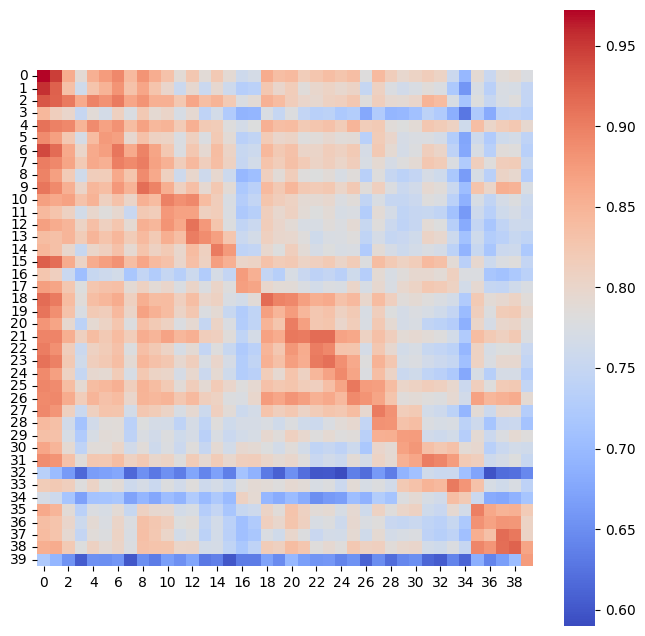

In [67]:
plt.figure(figsize=(8, 8))

sns.heatmap(cos_sim, square=True, cmap='coolwarm')

从这个图可以看出，并不是对角线是最相似的，有不少片段，都跟开头的两句相似度比较高